In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import warnings
warnings.filterwarnings('ignore')
sb.set_style("darkgrid")

In [2]:
df1 = pd.read_csv('van_xuoi.csv')
df2 = pd.read_csv('phi_hu_cau_va_binh_chon_nhieu_nhat.csv')
df3 = pd.read_csv('bo_sung.csv')
df4 = pd.read_csv('bo_sung_1.csv')
df5 = pd.read_csv('crawling_tiki_full.csv')

In [3]:
df3 = df3.loc[df3.rating < 4]
df4 = df4.loc[df4.rating < 4]

In [4]:
data = pd.concat([df1, df2, df3, df4, df5])
data.head()

Unnamed: 0                                               text  rating
0           0  [Có thể đòi hỏi gì thêm ở Dế mèn phiêu lưu ký ...     5.0
1           1  Dế Mèn Phiêu Lưu Ký, nó giống như Chúa Nhẫn vậ...     5.0
2           2  bạn nào rate thấp cho cuốn này thì có lẽ là do...     5.0
3           3  Ghét cái cuốn này. Ghét cay ghét đắng. Nhưng m...     1.0
4           4  Dế Mèn đúng là hình ảnh của các bé trai tuổi 6...     0.0

In [5]:
data = data.reset_index()
data = data.drop(columns = ['index', 'Unnamed: 0'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16235 entries, 0 to 16234
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    16235 non-null  object 
 1   rating  16235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 253.8+ KB


In [7]:
data.shape

(16235, 2)

In [8]:
data = data.drop_duplicates()
data.shape

(13819, 2)

In [9]:
data = data.reset_index()
data = data.drop(columns = ['index'])

In [10]:
data = data.loc[data['text'] != 'This review has been hidden because it contains spoilers. To view it, click here.']

In [11]:
data = data.reset_index()
data = data.drop(columns = ['index'])
data.shape

(13813, 2)

In [12]:
data = data.loc[data['rating'] != 0]
data = data.reset_index()
data = data.drop(columns = ['index'])
data.shape

(13433, 2)

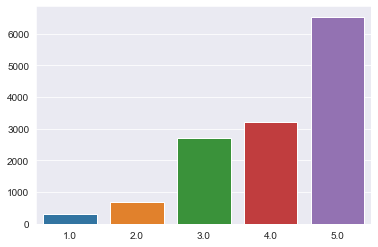

In [13]:
sb.barplot(x = data.rating.value_counts().index, y = data.rating.value_counts().values)
plt.show()

In [14]:
def evaluate(x,y):
    for i in range(len(data.rating)):
        if x[i] == 4 or x[i] == 5:
            y[i] = 'tích cực'
        elif data.rating[i] == 3:
            y[i] = 'trung tính'
        else:
            y[i] = 'tiêu cực'
    return y

In [15]:
data.evaluate = ' '
data = data.assign(evaluate = ' ')
data.evaluate = evaluate(data.rating, data.evaluate)
data.head()

text  rating  evaluate
0  [Có thể đòi hỏi gì thêm ở Dế mèn phiêu lưu ký ...     5.0  tích cực
1  Dế Mèn Phiêu Lưu Ký, nó giống như Chúa Nhẫn vậ...     5.0  tích cực
2  bạn nào rate thấp cho cuốn này thì có lẽ là do...     5.0  tích cực
3  Ghét cái cuốn này. Ghét cay ghét đắng. Nhưng m...     1.0  tiêu cực
4  Đọc lại hai lần vẫn thích và ấn tượng nhất đoạ...     4.0  tích cực

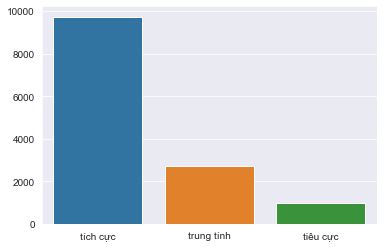

In [16]:
sb.barplot(x = data.evaluate.value_counts().index, y = data.evaluate.value_counts().values)
plt.show()

**Nhận xét**:
 - Tích cực chiếm số lượng nhiều nhất với trên 5000 lượt đánh giá
 - Tiêu cực chiếm số lượng ít nhất với chỉ khoảng 900 lượt đánh giá, với số lượng đánh giá tiêu cực ít như vậy có thể sẽ phải sử dụng oversampling

In [17]:
from langdetect import detect

In [18]:
data['detect_lang'] = ' '
data = data.assign(detect_lang = ' ')
for i in range(data.shape[0]):
    try:
        data['detect_lang'][i] = detect(data.text[i])
    except:
        continue

In [19]:
# Comments bằng tiếng Việt
data.loc[data.detect_lang == 'vi'].shape[0]

# Comments bằng tiếng Anh
data.loc[data.detect_lang == 'en'].shape[0]

1604

In [20]:
data_vn = data.loc[data.detect_lang == 'vi']
data_vn = data_vn.reset_index()
data_vn = data_vn.drop(columns = ['index'])

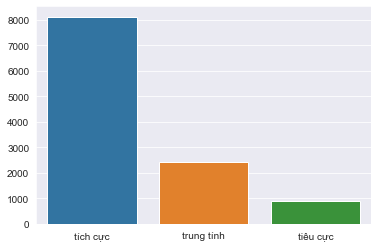

In [21]:
sb.barplot(x = data_vn.evaluate.value_counts().index, y = data_vn.evaluate.value_counts().values)
plt.show()

In [22]:
from underthesea import word_tokenize, pos_tag, sent_tokenize # sent_tokenize tách ra từ 1 văn bản thành nhiều câu
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string

In [23]:
##LOAD EMOJICON
file = open('Cung cap HV/files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('Cung cap HV/files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('Cung cap HV/files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('Cung cap HV/files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('Cung cap HV/files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [24]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+'  ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words   
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '                    
    document = new_sentence  
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [25]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [26]:
def replace_some_words(text):
    if 'thấy hay' in text or 'thấy thích' in text or 'chỉ nên' in text  or 'từng thích' in text\
    or 'nên đọc' in text or 'việt nam' in text or 'đừng đọc' in text or 'không hay' in text or 'khá hay' in text:
        
        text = text.replace('thấy hay', 'thấy_hay').replace('thấy thích', 'thấy_thích').replace('chỉ nên', 'chỉ_nên').\
        replace('từng thích', 'từng_thích').replace('việt nam', 'việt_nam').replace('đừng đọc', 'đừng_đọc').\
        replace('không hay', 'không_hay').replace('khá hay', 'khá_hay')
        
        return text
    else:
        return text

In [27]:
# có thể bổ sung thêm các từ: chẳng, chả...
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst or 'hơi' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không' or  word == 'hơi':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [28]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R' , 'M']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [29]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [30]:
data_vn['text_new'] = data_vn.text
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.lower().replace('(less)', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('cliche', 'rập khuôn'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dmplk', 'dế mèn phiêu lưu ký'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('trươca', 'trước'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('qđ', 'quyết định'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('goodread', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('đc', 'được'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dếmèn', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dếchoắt', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dấu ấn rồng thiên', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('sgk', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nbct', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dragon ball', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('tri chi vi tri chi, bất tri vi bất tri, thị tri dã', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('ndc', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('choux', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('muôn kiếp nhân sinh', '').replace('mkns', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('hành trình về phương đông', '').replace('htvpđ', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('haizzz', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nhéeee', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nhée', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nháa', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('fluential', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('havg', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bủnet', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('chips', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('vũ trọng phụng', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nam cao', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('lôi mễ', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nguyễn duy cần', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('rosie nguyễn', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('roise nguyễn', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('trang hạ', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('anh khang', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nguyễn ngọc thạch', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('vãn tình', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('trác nhã', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('midori', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('rosie', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bok', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('lê hồng phong', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('lê văn nghĩa', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('việ ', 'việc'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('tìn ', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('thíc ', 'thích '))

data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('ndung', 'nội dung'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('sach dep nhung noi dung khong nhu mong doi', 'sách đẹp nhưng nội dung không như mong đợi'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('khong thich cuon sach nay', 'không thích cuốn sách này'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('áp dung duoc', 'áp dụng được'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('thục tế', 'thực tế'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('phu hợp', 'phù hợp'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('sach khong hay, khong thu vi', 'sách không hay, không thú vị'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('noi dung khong phu hop voi thuc tien', 'nội dung không phù hợp với thực tiễn'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('rat de thuong, thuan khiet, trong sang. truyen nhu lan gio mat nhe nhe dua ta ve lai voi tuoi tho, voi nhung y nghi ngu ngo',
                                                                    'rất dễ thương, thuần khiết, trong sáng, truyện như làn gió mát nhè nhẹ đưa ta về lại với tuổi thơ, với những ý nghĩ ngu ngơ '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('thay truyen cua chu nguyen nhat anh quyen nao cung hay.van chuong cua chu bay bong ,cach dung tu rat hay va phong phu.quyen sach nay mang mot moi tinh rat dep,moc mac,chan that,dam chat lang que !quyen nay theo minh thi phu hop voi moi lua tuoi',
                                                                   'thấy truyện của chú nguyễn nhật ánh quyển nào cũng hay. văn chương của chú bay bổng, cách dùng từ rất hay và phong phú. quyển sách này mang một mối tình rất đẹp, mộc mạc, chân thật, đậm chất làng quê ! quyển này theo mình phù hợp với mọi lứa tuổi'))

data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('qá', 'quá'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nham chán', 'nhàm chán'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('hông', 'không'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('tkhông', 'thông'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('thuơg', 'thương'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('không búet', 'không biết'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('không biét', 'không biết'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('thuwcstinhr', 'thức tỉnh'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('binô', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bêtô', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bêto', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bvnsơn', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('zị', 'vậy'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('đỉm', 'điểm'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('tcn', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nguyễn bính', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('xuân diệu', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('rùi', 'rồi'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dễ thưn zữ z tr', 'dễ thương dữ vậy trời'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('chờy ơy pùn wa', 'trời ơi buồn quá'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('hok cóa', 'không có'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nọy', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nhín', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' child ', ' '))
  
                                                                    
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('đx', 'đối xử'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' k care', ' không quan tâm'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' hông ', ' không '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' chả ', ' không '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' chẳng ', ' không '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' ko ', ' không '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' k ', ' không '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' nh ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('vềmột', 'về một'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('cũngđã', 'cũng đã'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('ồnbị', 'ồn bị'))                                                                                                
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('lđếnà', 'là')) 
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nhưngnhà', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('buồ ', 'buồn '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('hậutuổithơ', ''))

data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nguyễn văn mãi', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('trọng hứa', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('nghiêm bình', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('thằng đắc', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('tô sang', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('lão hiến', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('lão hiếng', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('trần đăng khoa', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bê tô', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('chị ni', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dế', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dế mèn', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('dế choắt', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('xiến tóc', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('châu chấu voi', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bọ ngựa', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('cào cào', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('chim trả', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('chị nhà trò', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('êmê', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' mèn ', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' trũi ', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('chí phèo', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' c ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' g ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' n ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' h ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' t ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' r ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' th ', ' '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' ch ', ' '))

data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bằn', 'bằng'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('trắn ', 'trắng '))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('quyể ', 'quyển '))
 
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: re.sub(r'([a-z])\1+', lambda y:y.group(1), x))

In [31]:
# Đọc file ten_tac_pham
file = open('ten_tac_pham.txt', 'r', encoding="utf8")
name_of_books = file.read().split('\n')
file.close()

In [32]:
# Thay tên tác phẩm bằng khoảng trắng
for name in name_of_books:
    for i in range(data_vn.shape[0]):
        if name in data_vn['text_new'][i]:
            data_vn['text_new'][i] = data_vn['text_new'][i].replace(name, '')
        else:
            continue

In [33]:
# Đọc file ten_tac_gia
file = open('ten_tac_gia.txt', 'r', encoding="utf8")
name_of_authors = file.read().split('\n')
file.close()

In [34]:
# Thay tên tác giả bằng khoảng trắng
for name in name_of_authors:
    for i in range(data_vn.shape[0]):
        if name in data_vn['text_new'][i]:
            data_vn['text_new'][i] = data_vn['text_new'][i].replace(name, '')
        else:
            continue

In [35]:
# Bỏ các url
for i in range(data_vn.shape[0]):
    if 'https://' in data_vn.text_new[i]:
        data_vn.text_new[i] = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', data_vn.text_new[i], flags=re.MULTILINE)   
    else:
        continue
        

for i in range(data_vn.shape[0]):
    if 'http://' in data_vn.text_new[i]:
        data_vn.text_new[i] = re.sub('http://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', data_vn.text_new[i], flags=re.MULTILINE)   
    else:
        continue

for i in range(data_vn.shape[0]):
    if 'htps://' in data_vn.text_new[i]:
        data_vn.text_new[i] = re.sub('htps://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', data_vn.text_new[i], flags=re.MULTILINE)   
    else:
        continue

In [36]:
# Bỏ các trang web có đuôi .com, .vn hay .com.vn
for text in data_vn.text_new:
    if '.com' in text or '.vn' in text or '.com.vn' in text:
        re.sub('([a-z]+\.vn | [a-z]+\.com\.vn | [a-z]+\.com)', '', text)
    else:
        continue

In [37]:
i = 0
for comment in data_vn.text_new:
    document = process_text(comment, emoji_dict, teen_dict, wrong_lst)
    document = covert_unicode(document)
    document = replace_some_words(document)
    document = process_postag_thesea(document)
    document = remove_stopword(document,stopwords_lst)
    data_vn['text_new'][i] = document
    i = i + 1

In [38]:
data_vn.loc[data_vn.rating< 4]['text'][59]

'Sách khá hay, giá tiền nếu mua cuốn nhỏ cũng ko quá mắc. Câu chuyện của dế mèn như hành trình trưởng thành của mỗi con người vậy.'

In [39]:
data_vn.loc[data_vn.rating< 4]['text_new'][59]

'không_quá mắc'

In [40]:
' '.join(data_vn.text_new)

'đòi_hỏi phiêu_lưu thông dễ_dàng mắc bias review ký nhận_thức định_kiến hoàn_mĩ tuốt lạc nghỉ_hè cuộc_đời rẽ nhỏ_nhắn phiêu_lưu phiêu_lưu trông mặt_mũi không_rõ đọc liệu trải_nghiệm không_nhưng ký ý_nghĩa lôi_cuốn thơ_trẻ ký đẹp không_nằm thể_hiện sát phức_tạp ngược_lại thoáng toàn_mỹ ý_thức_hệ chủ_nghĩa thế_này kết_nối toàn sống không chí_tình mặc_cảm mãi_mãi phiêu_lưu ký chèn nhắc_nhở trôi đẹp rộng_rãi viết hơi_bị đọc muộn ghét ghét ghét đắng đọc cố đọc kiểu không_rút đọc khốn_khổ không chán đọc đọc hội_thoại kí thích dở_hơi bảo đọc phát khóc đọc lầm chán ngáp chảy nước_mắt không_đọc đọc đừng đụng không_đọc âu bố_mẹ chờ đọc đọc định đừng mất_công sửa chê đọc cứu_rỗi cám_ơn đọc thích ấn_tượng đẹp vẽ lệch hàm_chứa đọc đọc nxb đẹp đọc vô_cùng thích_thú tưởng_tượng hành_trình mèn đọc ngẫm không_giống đùm_bọc ganh_ghét đố giành đừng mãi sống khám_phá mới_mẻ đừng sợ ký mỏng đọc hoàn_thành mạnh_mẽ cố đọc không_làm thất_vọng ký nổi_tiếng trích_đoạn đọc mãi bốc đại đọc phiêu_lưu khắp học_hỏi 

In [41]:
for i in range(data_vn['text_new'].shape[0]):
    for word in data_vn['text_new'][i].split(' '):
        if '_' in word:
            continue
        else:
            if word == '':
                continue
            elif detect(word) == 'vi':
                continue
            else:
                data_vn['text_new'][i] = data_vn['text_new'][i].replace(word, '')

In [42]:
wrong = re.findall('\w+\_\s{1}', ' '.join(data_vn['text_new']))
unique = []
for word in wrong:
    if word not in unique:
        unique.append(word)
    else:
        continue

In [43]:
wrong_1 = re.findall('\s{1}\_\w+', ' '.join(data_vn['text_new']))
unique_1 = []
for word in wrong_1:
    if word not in unique_1:
        unique_1.append(word)
    else:
        continue

In [44]:
for word in unique:
    data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(word, ''))
    
for word in unique_1:
    data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(word, ''))

In [45]:
# ' '.join(data_vn['text_new'])

In [46]:
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace(' c_giả', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('củavàđối', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('sáchay', 'sách hay'))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('gp', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('bok', ''))
data_vn['text_new'] = data_vn['text_new'].apply(lambda x: x.replace('sasas tácgiảviệtnamhaynhất tìmìnhtrongthếgiới', ''))

In [47]:
for i in range(data_vn['text_new'].shape[0]):
    data_vn['text_new'][i] = re.sub(r'\s+', ' ', data_vn['text_new'][i])

In [48]:
# data_vn.loc[data_vn.rating< 4]

In [49]:
def unique(x):
    list_words = []
    x = x.split(' ')
    for word in x:
        if word not in list_words:
            list_words.append(word)
    return list_words

In [50]:
unique_words = unique(' '.join(data_vn.text_new))
len(unique_words)

11859

In [51]:
dic = {}
for word in unique_words:
    dic[word] = ' '.join(data_vn.text_new).count(word)

In [52]:
dictionary = {'Word' : list(dic.keys()), 'Count': list(dic.values())}
df_word = pd.DataFrame(dictionary).sort_values(by = ['Count'], ascending = False)
df_word.head()

Word   Count
24         989973
8853    n   86224
2030    h   78442
4077    _   70732
4253    t   62410

In [53]:
# Tìm các từ xuất hiện nhiều hơn 150 lần
df_word[(df_word.Count > 150)].Word.values[1:]

array(['n', 'h', '_', 't', 'c', 'g', 'ng', 'đ', 'th', 'ọ', 'ch', 'k',
       'đọ', 'đọc', 'r', 'ế', 'ả', 'ôn', 'b', 's', 'ố', 'hô', 'hôn', 'ê',
       'khô', 'khôn', 'không', 'ết', 'gi', 'ph', 'hà', 'x', 'hư', 'hí',
       'ị', 'ứ', 'viết', 'ơn', 'há', 'híc', 'hích', 'thí', 'ồn', 'thích',
       'tư', 'học', 'ân', 'gh', 'giả', 'hàn', 'sốn', 'sống', 'ương', 'hú',
       'cảm', 'thư', 'ắc', 'hành', 'hân', 'yêu', 'lắ', 'ẹp', 'âu', 'đẹ',
       'đẹp', 'iên', 'tác', 'hơ', 'hạ', 'ôi', 'ập', 'lắm', 'rẻ', 'ức',
       'âm', 'ù', 'trẻ', 'buồn', 'ải', 'tố', 'tác_giả', 'thươn', 'thương',
       'lạ', 'thành', 'ối', 'chế', 'độ', 'hận', 'oà', 'ủ', 'sâu', 'tì',
       'tốt', 'yên', 'đô', 'đa', 'chết', 'phá', 'hơi', 'kế', 'việt',
       'hiên', 'ứng', 'tâm', 'văn', 'tình', 'kết', 'hụ', 'giá', 'ồng',
       'cư', 'hực', 'uyên', 'thực', 'hiện', 'thú', 'sắc', 'giúp', 'đổ',
       'ườn', 'đôi', 'tưởng', 'vô', 'tả', 'truyện', 'hất', 'ắng', 'ới',
       'đạ', 'ấn', 'gắn', 'nhân', 'thức', 'đổi', 'iêu', 'rả'

In [ ]:
# re.findall('\w+\_\w+',' '.join(df_word[(df_word.Count > 150)].Word.values[1:].tolist()))

In [54]:
# Chuyển về dạng list và giữ lại 2 từ không_thích 
lst_word_over_150 = df_word[(df_word.Count > 150) & (df_word.Word != 'không_thích') & (df_word.Word != 'đơn_giản')
                           & (df_word.Word != 'không_hiểu') & (df_word.Word != 'chán')
                           & (df_word.Word != 'hấp_dẫn') & (df_word.Word != 'ý_nghĩa')
                           & (df_word.Word != 'bình_thường') & (df_word.Word != 'xuất_sắc') 
                           & (df_word.Word != 'lặp') & (df_word.Word != 'dở')].Word.values[1:].tolist()

In [ ]:
# ' '.join(data_vn.loc[data_vn.rating < 4].text_new)

In [55]:
stopwords_lst = stopwords_lst + lst_word_over_150

In [56]:
def unique_words(x):
    list_words = []
    x = x.split(' ')
    for word in x:
        if word not in list_words:
            list_words.append(word)
    return list_words

In [57]:
from wordcloud import WordCloud, STOPWORDS

In [58]:
tich_cuc = data_vn.loc[data_vn['evaluate'] == 'tích cực'].text_new
tich_cuc = ' '.join(tich_cuc)

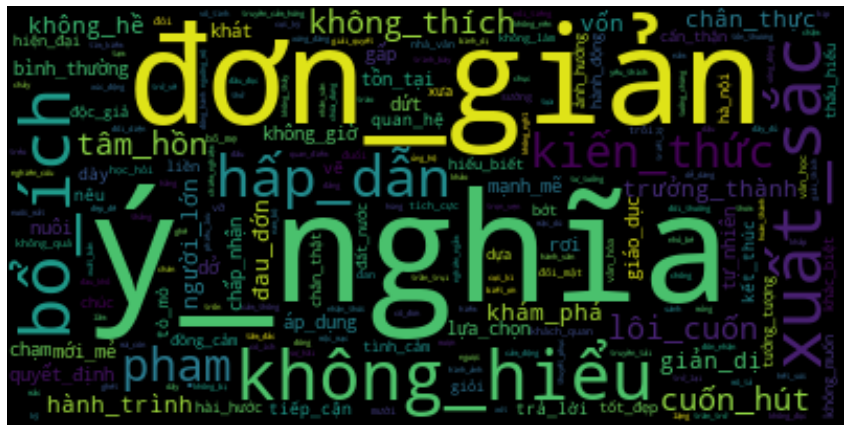

In [59]:
wc = WordCloud(
    background_color='black',stopwords = stopwords_lst)
wc.generate(tich_cuc)
plt.figure(figsize=(15, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
############################################################################

In [61]:
tieu_cuc = data_vn.loc[data_vn['evaluate'] == 'tiêu cực'].text_new
tieu_cuc = ' '.join(tieu_cuc)

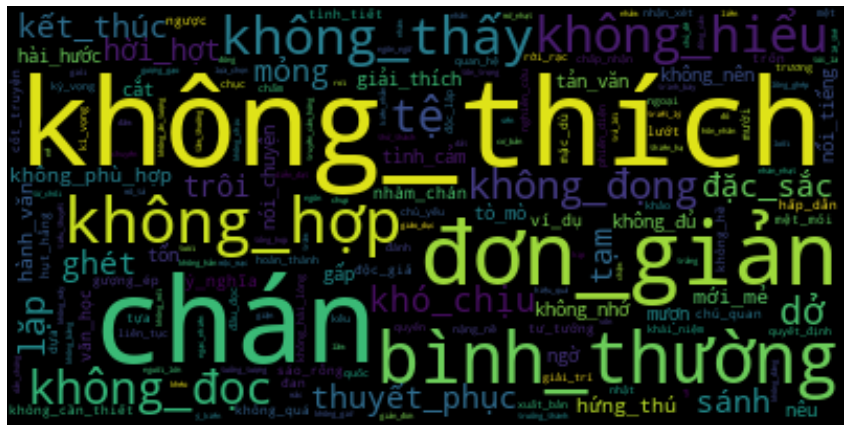

In [62]:
wc = WordCloud(
    background_color='black',stopwords = stopwords_lst)
wc.generate(tieu_cuc)
plt.figure(figsize=(15, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [63]:
############################################################################

In [64]:
binh_thuong = data_vn.loc[data_vn['evaluate'] == 'trung tính'].text_new
binh_thuong = ' '.join(binh_thuong)

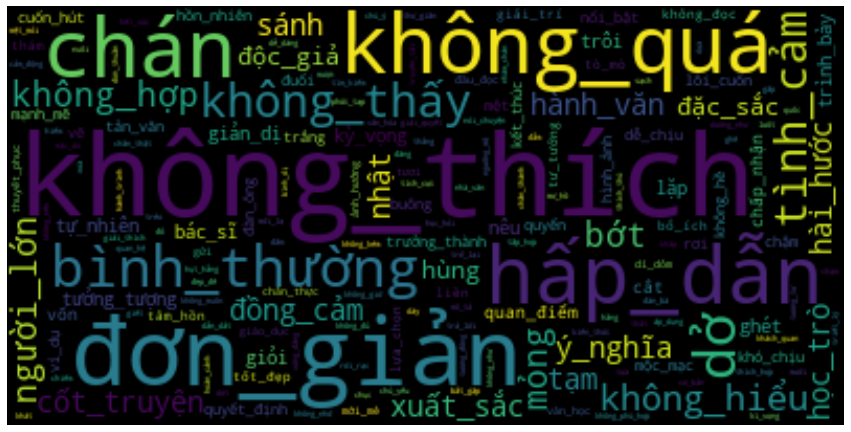

In [65]:
wc = WordCloud(
    background_color='black',stopwords = stopwords_lst)
wc.generate(binh_thuong)
plt.figure(figsize=(15, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [66]:
' '.join(data_vn.text_new)

'đòi_hỏi phiêu_lưu thông dễ_dàng mắc nhận_thức định_kiến hoàn_mĩ tuốt lạc nghỉ_hè cuộc_đời rẽ nhỏ_nhắn phiêu_lưu phiêu_lưu trông mặt_mũi không_rõ đọc liệu trải_nghiệm không_nhưng ý_nghĩa lôi_cuốn thơ_trẻ  đẹp không_nằm thể_hiện phức_tạp ngược_lại thoáng toàn_mỹ ý_thức_hệ chủ_nghĩa thế_này kết_nối toàn sống không chí_tình mặc_cảm mãi_mãi phiêu_lưu chèn nhắc_nhở trôi đẹp rộng_rãi viết hơi_bị đọc muộn ghét ghét ghét đắng đọc cố đọc kiểu không_rút đọc khốn_khổ không chán đọc đọc hội_thoại thích dở_hơi bảo đọc phát khóc đọc lầm chán ngáp chảy nước_mắt không_đọc đọc đừng đụng không_đọc âu bố_mẹ chờ đọc đọc định đừng mất_công sửa chê đọc cứu_rỗi cám_ơn đọc thích ấn_tượng đẹp vẽ lệch hàm_chứa đọc đọc đẹp đọc vô_cùng thích_thú tưởng_tượng hành_trình đọc ngẫm không_giống đùm_bọc ganh_ghét đố giành đừng sống khám_phá mới_mẻ đừng sợ  mỏng đọc hoàn_thành mạnh_mẽ cố đọc không_làm thất_vọng nổi_tiếng trích_đoạn đọc bốc đại đọc phiêu_lưu khắp học_hỏi tìm_tòi gặp_gỡ xốc_nổi nhiêu vỡ_lẽ trở bài_học củav

In [67]:
' '.join(data_vn.text)

'[Có thể đòi hỏi gì thêm ở Dế mèn phiêu lưu ký - Khó!]\n\nCon người là một giống loài tuyệt vời nhưng cũng đầy lỗi lầm. Thông minh tuyệt đỉnh nhưng luôn dễ dàng mắc phải những sai lệch về nhận thức (cognitive bias). Để review Dế mèn phiêu lưu ký, tôi cũng sẽ để nhận thức của bản thân sai lệch một chút, định kiến nhiều chút. Vì đây là cuốn sách đầu tiên, là cuốn sách đầu đời của tôi. Và tôi thấy nó thật hoàn mĩ.\n\nNgày ấy mẹ tôi còn bán hàng tuốt tận đường Lạc Long Quân, còn tôi thì mới nghỉ hè sau năm học đầu tiên của cuộc đời. Đó là một buổi trưa đi bộ cùng mẹ, khi rẽ qua một cửa hiệu sách tôi cũng không còn nhớ rõ vì lý do gì mà tôi chọn cho mình cuốn sách nhỏ nhắn cỡ chừng bỏ vừa túi mang tên "Dế mèn phiêu lưu ký".\n\nTất cả những gì một đứa trẻ cần chính là những chuyến phiêu lưu. Khi ấy tôi còn chưa biết thế nào là Dế, Dế mèn trông mặt mũi ra sao, thế nhưng chẳng gì có thể khiến cuộc phiêu lưu của tôi với cuốn sách ít cuốn hút đi. Tôi không rõ đến giờ đọc lại liệu mọi ký ức và tr

In [68]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [69]:
tf = TfidfVectorizer(stop_words = stopwords_lst, max_features = 5000, min_df=5,max_df= 0.8)
tf_transformed = tf.fit_transform(data_vn['text_new'])
tf_data = pd.DataFrame(tf_transformed.toarray(), columns = tf.get_feature_names()).add_prefix('tf_')
data_new = pd.concat([tf_data, data_vn[['evaluate']]], axis = 1)

In [70]:
data_new['evaluate'] = data_new['evaluate'].map(lambda x: 0  if x == 'tích cực'  else (1 if x == 'trung tính' else 2)) 

In [71]:
data_new

tf_biên  tf_biên_giới  tf_biên_soạn  tf_biên_tập  tf_biến_chuyển  \
0          0.0           0.0           0.0          0.0             0.0   
1          0.0           0.0           0.0          0.0             0.0   
2          0.0           0.0           0.0          0.0             0.0   
3          0.0           0.0           0.0          0.0             0.0   
4          0.0           0.0           0.0          0.0             0.0   
...        ...           ...           ...          ...             ...   
11449      0.0           0.0           0.0          0.0             0.0   
11450      0.0           0.0           0.0          0.0             0.0   
11451      0.0           0.0           0.0          0.0             0.0   
11452      0.0           0.0           0.0          0.0             0.0   
11453      0.0           0.0           0.0          0.0             0.0   

       tf_biến_chất  tf_biết_ơn  tf_biểu_diễn  tf_biểu_tượng  tf_biện  ...  \
0               0.0         0.0           0.0            0.0      0.0  ...   
1               0.0         0.0           0.0            0.0      0.0  ...   
2               0.0         0.0           0.0            0.0      0.0  ...   
3               0.0         0.0           0.0            0.0      0.0  ...   
4               0.0         0.0           0.0            0.0      0.0  ...   
...             ...         ...           ...            ...      ...  ...   
11449           0.0         0.0           0.0            0.0      0.0  ...   
11450           0.0         0.0           0.0            0.0      0.0  ...   
11451           0.0         0.0           0.0            0.0      0.0  ...   
11452           0.0         0.0           0.0            0.0      0.0  ...   
11453           0.0         0.0           0.0            0.0      0.0  ...   

       tf_ẩn_ý  tf_ốm  tf_ồn_ào  tf_ổn_định  tf_ủi  tf_ủng_hộ  tf_ức_chế  \
0          0.0    0.0       0.0         0.0    0.0        0.0        0.0   
1          0.0    0.0       0.0         0.0    0.0        0.0        0.0   
2          0.0    0.0       0.0         0.0    0.0        0.0        0.0   
3          0.0    0.0       0.0         0.0    0.0        0.0        0.0   
4          0.0    0.0       0.0         0.0    0.0        0.0        0.0   
...        ...    ...       ...         ...    ...        ...        ...   
11449      0.0    0.0       0.0         0.0    0.0        0.0        0.0   
11450      0.0    0.0       0.0         0.0    0.0        0.0        0.0   
11451      0.0    0.0       0.0         0.0    0.0        0.0        0.0   
11452      0.0    0.0       0.0         0.0    0.0        0.0        0.0   
11453      0.0    0.0       0.0         0.0    0.0        0.0        0.0   

       tf_ứng_dụng  tf_ứng_xử  evaluate  
0              0.0        0.0         0  
1              0.0        0.0         0  
2              0.0        0.0         0  
3              0.0        0.0         2  
4              0.0        0.0         0  
...            ...        ...       ...  
11449          0.0        0.0         0  
11450          0.0        0.0         0  
11451          0.0        0.0         0  
11452          0.0        0.0         0  
11453          0.0        0.0         0  

[11454 rows x 3042 columns]

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X = data_new.drop(columns = ['evaluate'])
Y = data_new.evaluate

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 41)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import datetime
from sklearn.metrics import accuracy_score
import math
from lightgbm import LGBMClassifier

In [76]:
model = MultinomialNB()
model.fit(X_train, Y_train)

MultinomialNB()

In [77]:
Y_pred = model.predict(X_test)

In [78]:
acc = accuracy_score(Y_pred, Y_test)
acc

0.7360335195530726

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [80]:
print(confusion_matrix(Y_pred, Y_test))

[[2053  522  190]
 [  13   55   31]
 [   0    0    0]]


In [81]:
################################################################

In [82]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [83]:
smote = SMOTE()
X_S_train, Y_S_train = smote.fit_resample(X_train, Y_train)
print(sorted(Counter(Y_S_train).items()))

[(0, 6063), (1, 6063), (2, 6063)]


In [ ]:
model1 = MultinomialNB()
model1.fit(X_S_train, Y_S_train)

In [ ]:
Y_pred_1 = model1.predict(X_test)

In [ ]:
acc1 = accuracy_score(Y_pred_1, Y_test)
acc1

In [ ]:
print(confusion_matrix(Y_pred_1, Y_test))

In [ ]:
detect('hay')